# Team members: 
Anqi Chen, Wenyun Wang, Hanyue Wang

# References:
- "Time Series Analysis with Applications in R" by Jonathan D. Cryer and Kung-Sik Chan

- https://docs.pymc.io/en/v3/pymc-examples/examples/time_series/AR.html

- https://en.wikipedia.org/wiki/Autoregressive_model


In [1]:
import condensate_speckle

# General model & simulating data

We are using first order autoregression model as our general model. The overal general form of autoregression model is $Y_t=\sum_{i=1}^{p}\phi_i\times Y_{t-i}+e_t$, where Y is the intensity value, $\phi_i$ is parameters that depends on $\tau$, $e_t$ is the innovation term. For this project, we are using first-order approximation only, known as AR(1) model. That is $$Y_t=\phi\times Y_{t-1}+e_t$$
, where $\phi=\exp(-1/\tau)$. So the equation becomes $Y_t=\exp(-1/\tau)\times Y_{t-1}+e_t$. 

To generate data, variable we need are the distibution of $e_t$, including their mean $c$ and standard deviation $\sigma_e$, and $\tau$. Here, $e_t$ is considered as Gaussian distribution. $\tau$ is the value we decide on. We also need the distribution noise level of microscope, which is assumed to be a Normal distribution as well.

The overall intensity mean can be calculated by $\frac{c}{1-\phi}$ and the intensity variance is $\frac{\sigma_e^2}{1-\phi^2}$. 

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pymc3 as pm
import arviz as az

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [3]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 10
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [29]:
number_data_point = 5000

# A probabilistic generator for the innovation term.
innovation_mean = 1 # this is the c term in the wikipedia construction
innovation_std = 1 # this is the standard deviation of the innovation 
innovation = np.random.normal(loc=0.0, scale=innovation_std, size = number_data_point)

# A probabilistic generator for tao
tao_mean = 50
tao_std = 0
tao = np.random.normal(loc=tao_mean, scale=tao_std, size = number_data_point)


intensity_mean = innovation_mean / (1 - np.exp(-1/tao_mean)) # this is the expectation value of all intensity signals
intensity_variance = innovation_std**2 / (1 - np.exp(-2/tao_mean)) # this is the expectation value of all intensity signals
X = intensity_mean*np.ones(number_data_point) #initialize data matrix

print('The mean intensity is {}'.format(intensity_mean))
print('The variance of intensity is {}'.format(intensity_variance))
print('variance normalized by mean-squared is {}. This will be the magnitude of the first pt of the Autocorrelation function'.format(intensity_variance/intensity_mean**2))

The mean intensity is 50.50166665555553
The variance of intensity is 25.50333324444781
variance normalized by mean-squared is 0.009999666679999504. This will be the magnitude of the first pt of the Autocorrelation function


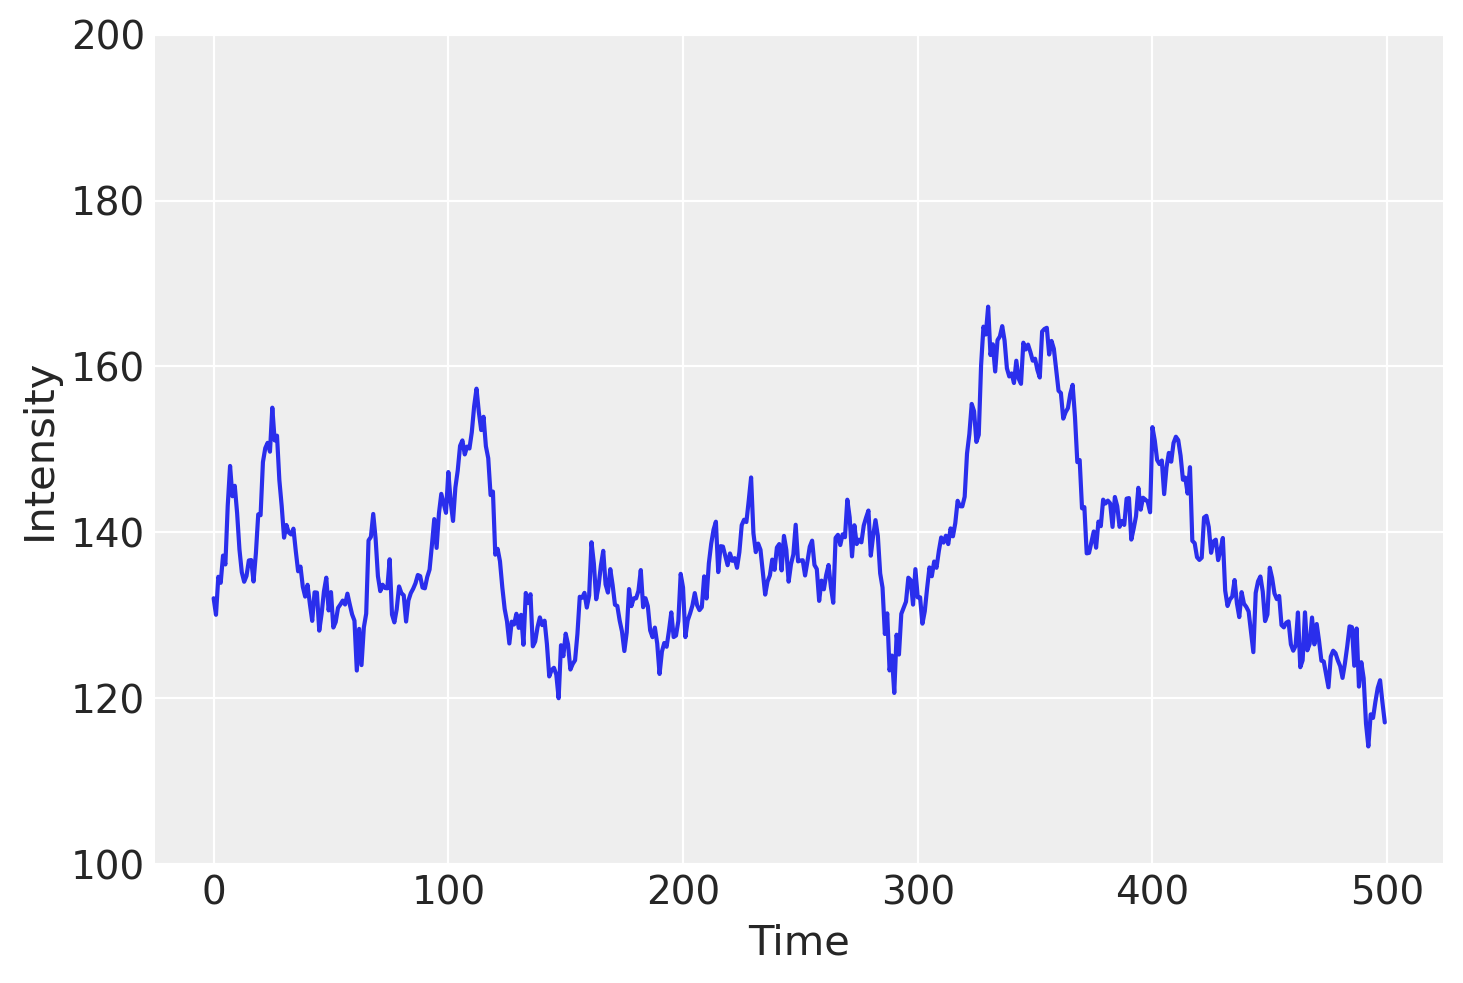

In [32]:
#Generate model data
phi = np.exp(-1/tao)
for i in np.arange(number_data_point-1):
    X[i+1]= innovation_mean + phi[i]*X[i] + innovation[i] # Data not normalized
    
X_normalized = X/intensity_mean

#Add camera noise

camera_noise_mean = 5
camera_noise_std = 1
camera_noise = np.random.normal(loc = camera_noise_mean, scale = camera_noise_std, size = number_data_point)

quantization = 255 # 8 bit image
image_brightness = 0.5 # the brightness of image divided by full quantization

X_simulated_data = X_normalized*quantization*image_brightness+camera_noise

#Plot model data
#plt.plot(np.arange(number_data_point),X_normalized,'o')
plt.plot(np.arange(number_data_point)[0:500],X_simulated_data[0:500],'-')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.ylim([100,200])
plt.show()

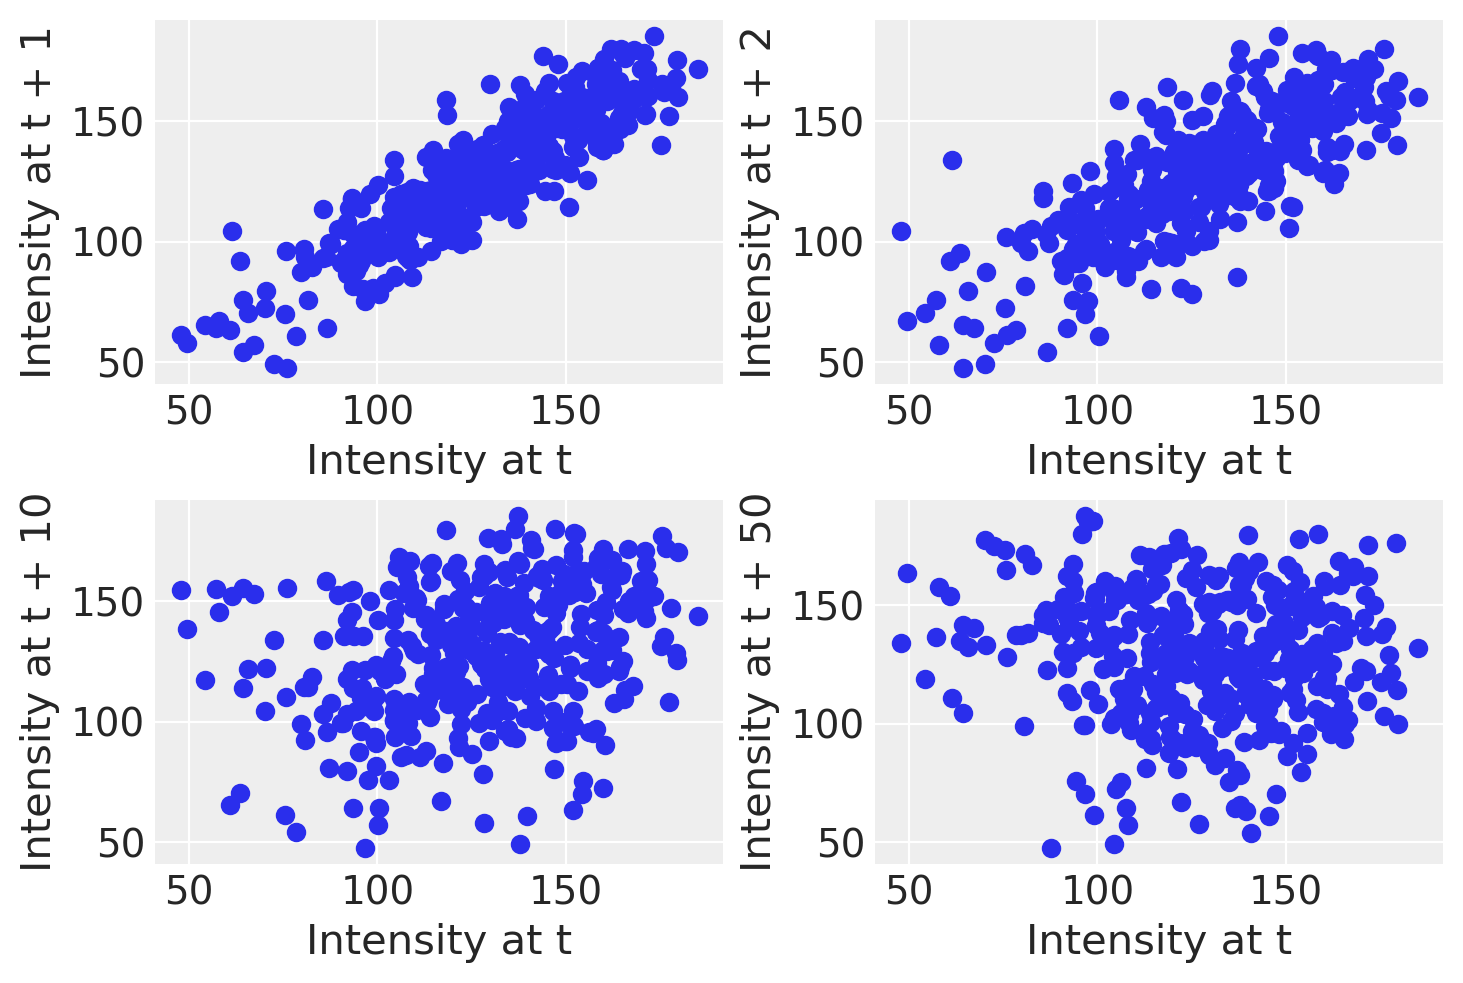

In [26]:
#Correlation between neighboring pts
averaged_pts = 400 
pth_neighbor = np.array([1,round(0.2*tao_mean),round(tao_mean),round(5*tao_mean)])
number_correlation_illustration = len(pth_neighbor)
for i in np.arange(number_correlation_illustration):
    plt.subplot(2,2,i+1)
    #plt.plot(X_normalized[0:averaged_pts],X_normalized[pth_neighbor[i]:pth_neighbor[i]+averaged_pts],'o')
    plt.plot(X_simulated_data[0:averaged_pts],X_simulated_data[pth_neighbor[i]:pth_neighbor[i]+averaged_pts],'o')
    plt.xlabel('Intensity at t')
    #plt.ylabel('$X_{t+1}$'.format(pth_neighbor))
    plt.ylabel('Intensity at t + {}'.format(pth_neighbor[i]))
plt.show()

Autocorrelation:

$\frac{<I(t)I(t+\tau)>}{<I(t)><I(t+\tau)>} - 1$

/var/folders/wf/qxrbnsmd4xn7cplm95fm264w0000gn/T/ipykernel_37951/3127761177.py:20: RuntimeWarning: invalid value encountered in log
  plt.plot(lag_time,np.log(Autocorrelation),'o')


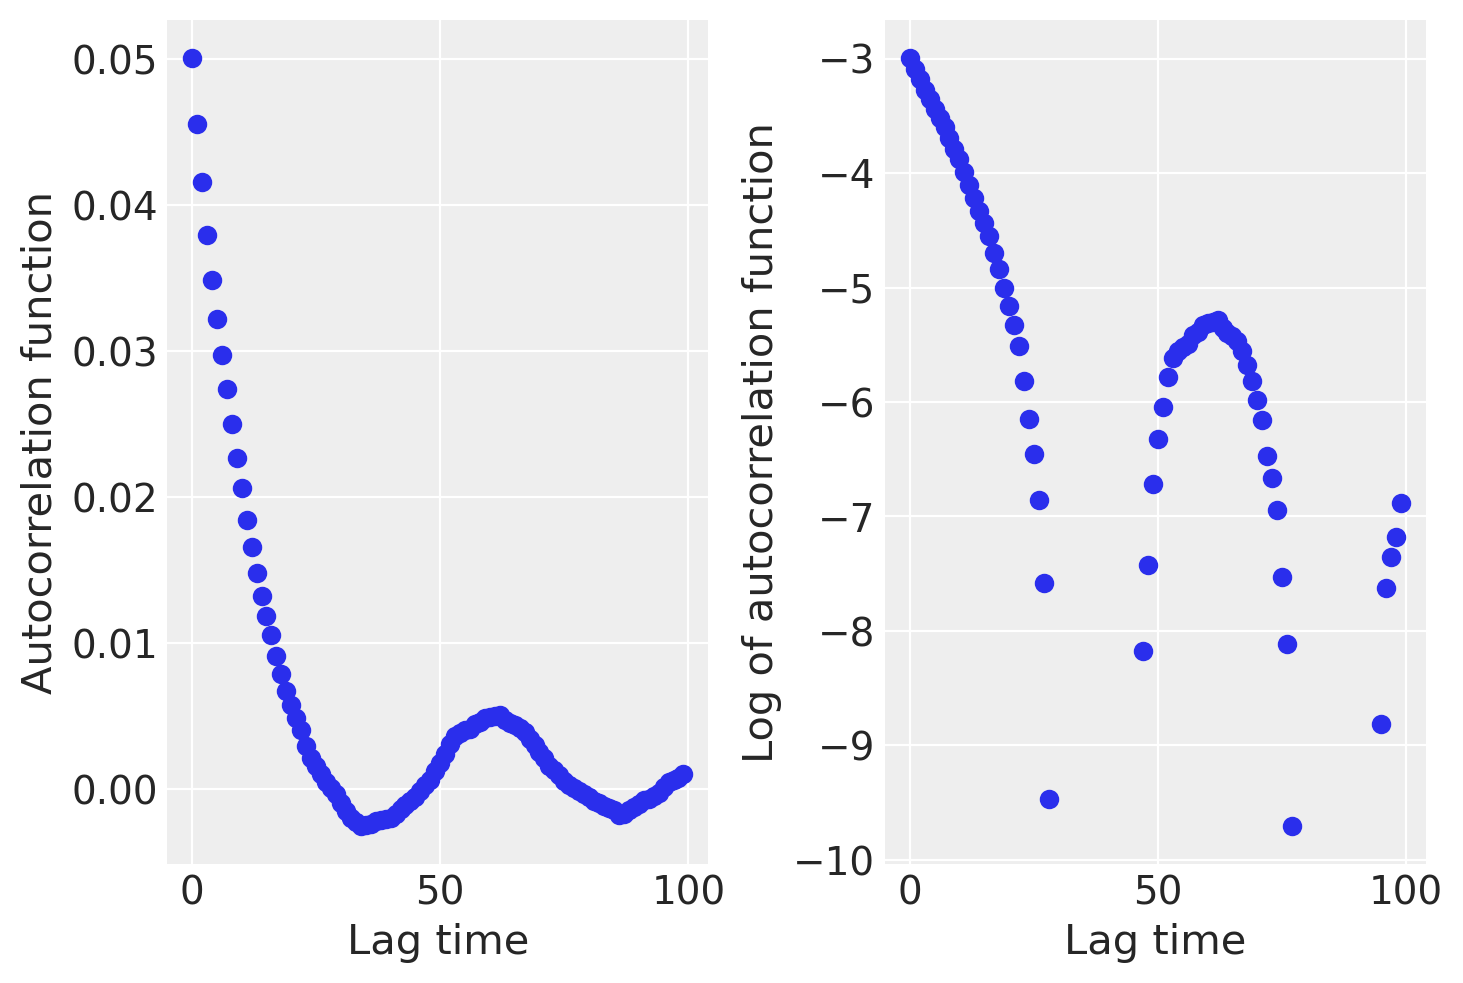

In [27]:
# Autocorrelation function
longest_lag_time = 100
lag_time = np.arange(longest_lag_time)
averaged_pts = 4000 #Need averaged_pts+lognes_lag_time < number_data_point
Intensity_matrix = np.zeros([longest_lag_time,averaged_pts])
Correlation_matrix = np.zeros([longest_lag_time,averaged_pts])

for i in lag_time:
    #Intensity_matrix[i] = X_normalized[i:i+averaged_pts] 
    Intensity_matrix[i] = X_simulated_data[i:i+averaged_pts] 
    Correlation_matrix[i] = Intensity_matrix[0]*Intensity_matrix[i]

Autocorrelation = np.average(Correlation_matrix, axis = 1) / (np.average(Intensity_matrix[0])*np.average(Intensity_matrix, axis = 1)) - 1

plt.subplot(121)
plt.plot(lag_time,Autocorrelation,'o')   
plt.xlabel('Lag time')
plt.ylabel('Autocorrelation function')
plt.subplot(122)
plt.plot(lag_time,np.log(Autocorrelation),'o')   
plt.xlabel('Lag time')
plt.ylabel('Log of autocorrelation function')
plt.show()

# Fitting simulated data with pymc3 AR(1) model

To fit our model AR1 model, we want to extract the following parameters: decay time, which is the $\tau$ above; stationary is the $\phi$, precision is defined as $\frac{1}{\sigma_e^2}$; center is the innovation mean. Our prior for $\tau$ is uniform from 0 to 50, based on the experimental data time scale; for precision, we also use a uniform prior from 0 to 10 times the calculated precision from simulation parameters; for center, it is uniform from the lowest possible intensity to the highest possible intensity.

Thus, the statistical model we use is:
$$ \tau \sim \text{Uniform} (0,50) $$
$$ \text{precision} \sim \text{Uniform} (0, \text{upper}) $$
$$ \mu \sim \text{Uniform} (I_{min}, I_{max}) $$
$$ p(X) \sim \text{AR1} (\text{k} = e^{-1/\tau}, \text{tau_e} = \text{precision}, \text{observed} = X-\mu )$$

In [15]:
# Bayesian parameter estimation with pymc3
ar1_model = pm.Model()

with ar1_model:
    
    # 'phi'is ln(-1/tau) used in our generative model
    decay_time = pm.Uniform("decay_time",lower = 0, upper = 50) 
    stationarity = np.exp(-1/decay_time)

    # 'precision' is 1/(variance of innovation). As we use normalized data, this term has to be divided by intensity_mean squared
    precision = pm.Uniform("precision", lower = 0 , upper = 10/(np.var(X_simulated_data)*(1-np.exp(-2/10)))) 
    # process mean
    center = pm.Uniform("center", lower = 0, upper = quantization) # this is the mean of normalized data
    
    # camera noise
    #noise = pm.Normal("noise",mu = 5, sigma = 1)
    
    likelihood = pm.AR1("y", k=stationarity, tau_e=precision, observed = X_simulated_data - center)

In [ ]:
# # Bayesian parameter estimation with pymc3
# ar1_model = pm.Model()

# with ar1_model:
    
#     # 'phi'is ln(-1/tau) used in our generative model
#     decay_time = pm.Uniform("decay_time",lower = 0, upper = 50) 
#     stationarity = np.exp(-1/decay_time)

#     # 'precision' is 1/(variance of innovation). As we use normalized data, this term has to be divided by intensity_mean squared
#     precision = pm.Uniform("precision", lower = 0 , upper = 10/(innovation_std**2/(intensity_mean/(quantization*image_brightness))**2)) 
#     # process mean
#     center = pm.Uniform("center", lower = 0, upper = quantization) # this is the mean of normalized data
    
#     # camera noise
#     camera_noise = pm.Normal("camera_noise",mu = 10, sigma = 1,shape = 5000)
    
#     likelihood_noise = []
#     likelihood_AR1 = []
#     for i in noise_bins:
#         likelihood_noise.append(pm.Normal.dist(mu = 10, sigma = 1).logp(noise_bins[i]))
#         #likelihood = pm.AR1("y", k=phi, tau_e=precision, observed = X_normalized - center)
#         #likelihood_AR1.append(pm.AR1.dist(k=stationarity, tau_e=precision).logp(X_simulated_data-noise_bins[i]))
    
#     likelihood_AR1 = pm.AR1.dist(testval = X_simulated_data[0], k=stationarity, tau_e=precision).logp(X_simulated_data-noise_bins)
#     pm.Potential("likelihood",likelihood_AR1+likelihood_noise)

In [16]:
estimate = pm.find_MAP(model = ar1_model)

In [17]:
with ar1_model:
    trace = pm.sample(1000, tune=2000, init="advi+adapt_diag", random_seed=RANDOM_SEED)
    idata = az.from_pymc3(trace)

/var/folders/4c/vpfj2cz13377t1cw_xxjyj4w0000gn/T/ipykernel_25989/137214802.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000, tune=2000, init="advi+adapt_diag", random_seed=RANDOM_SEED)
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 20100
Interrupted at 20,099 [10%]: Average Loss = 20,672
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [center, precision, decay_time]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 17 seconds.


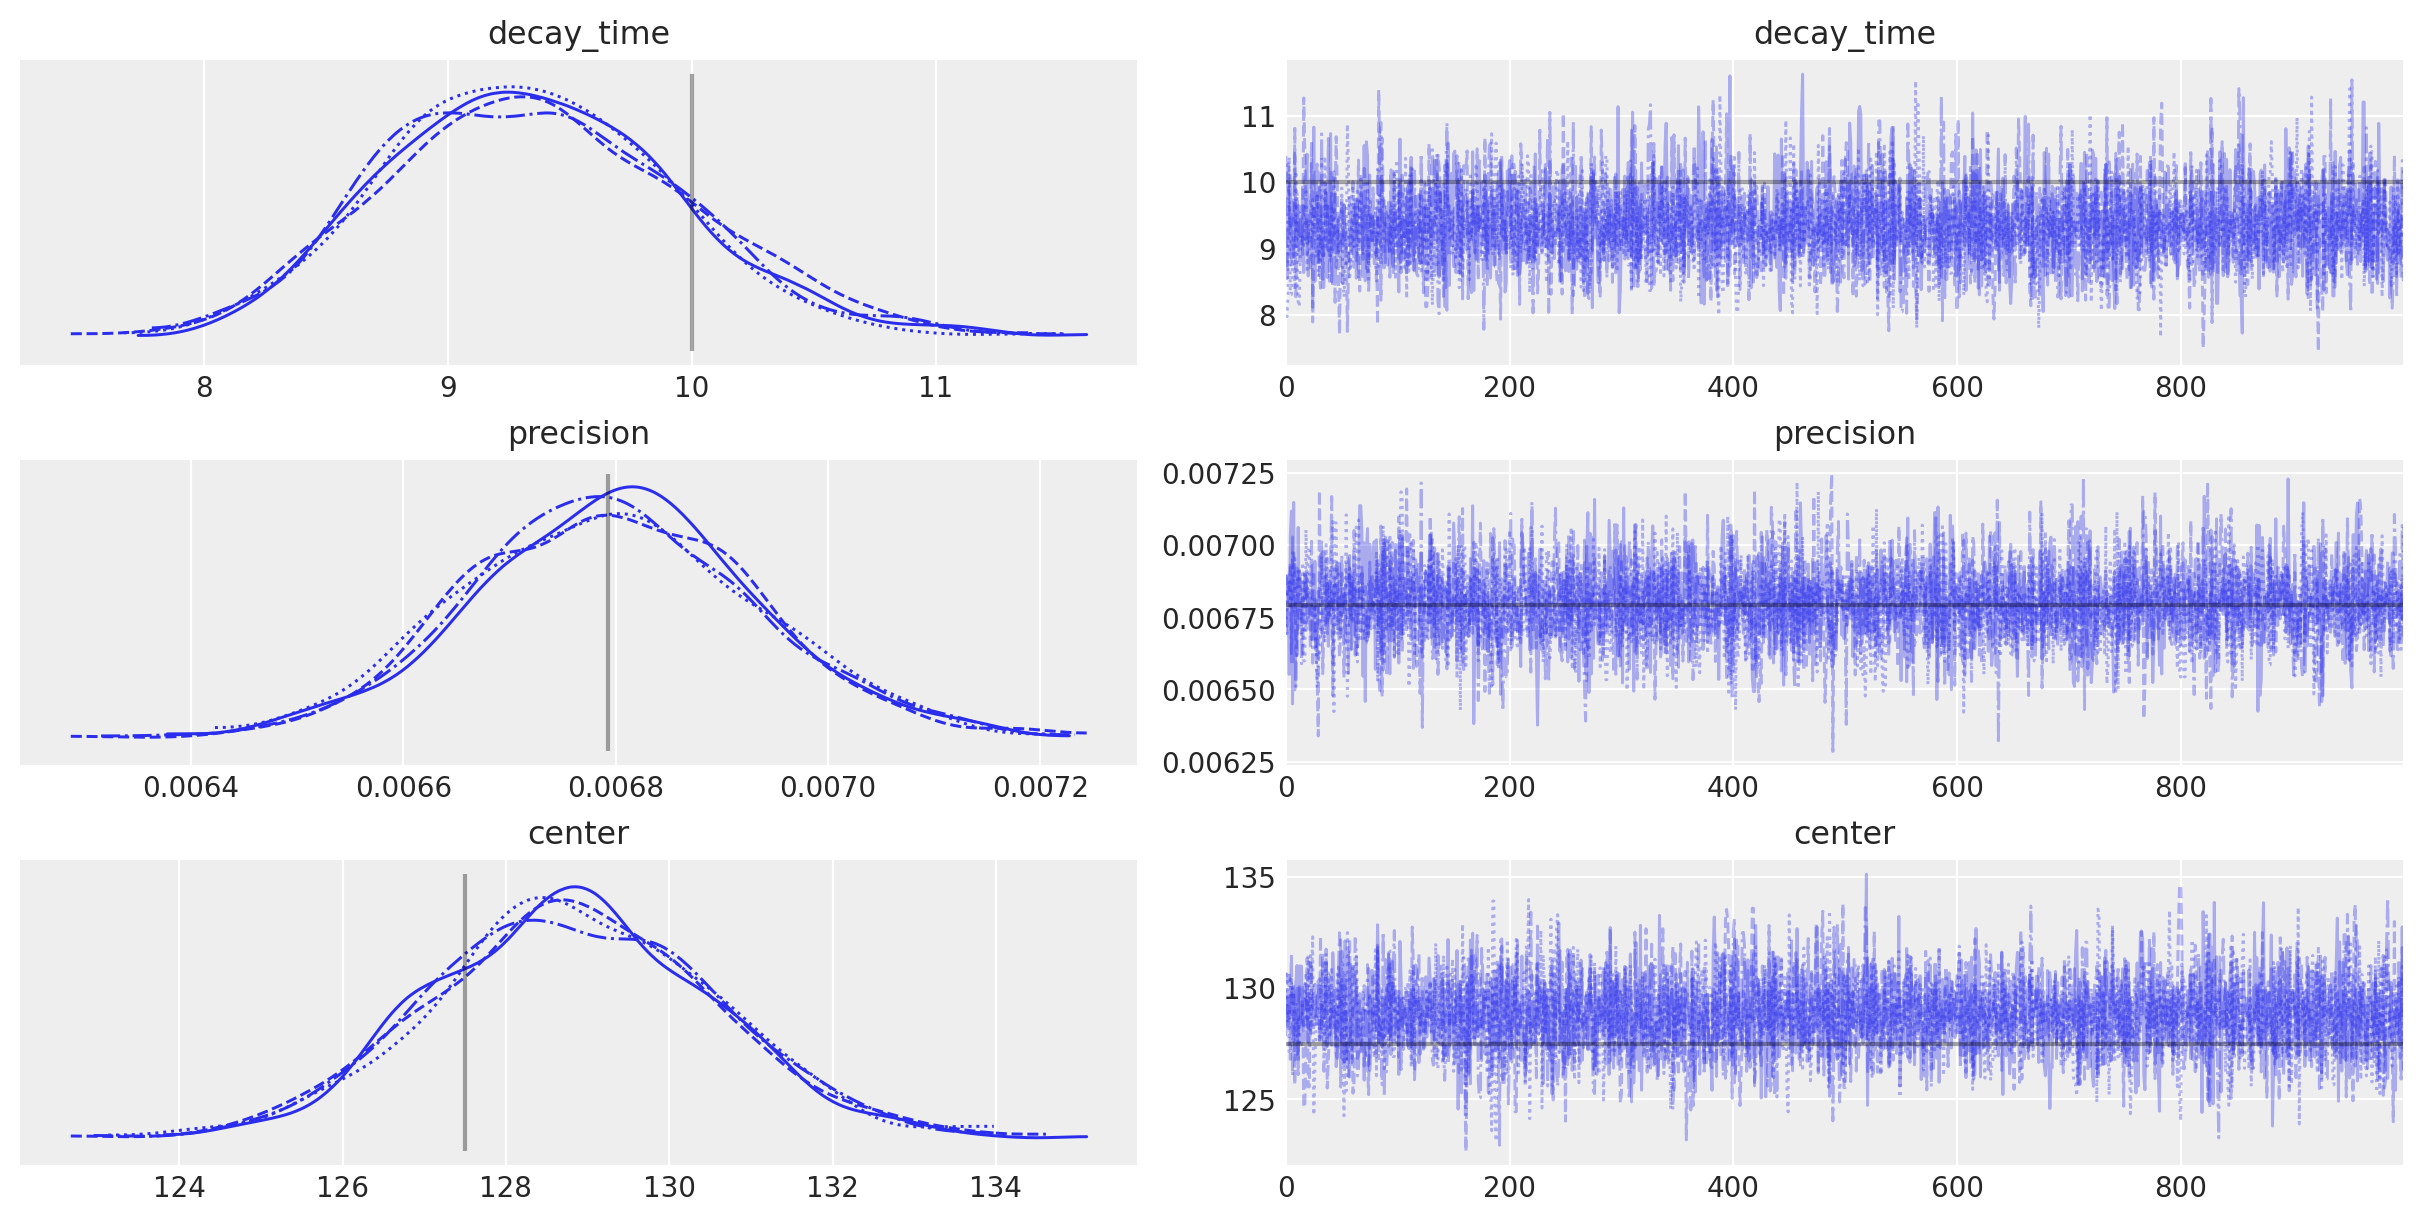

In [18]:
az.plot_trace(
    idata,
    lines=[
        ("decay_time", {}, tao_mean),
        ("precision", {}, 1/(innovation_std**2/(intensity_mean/(quantization*image_brightness))**2)),
        ("center", {}, quantization*image_brightness),
    ],
);